In [1]:
import json
import pandas as pd

def calculate_reimbursement(trip_duration_days, miles_traveled, total_receipts_amount):
    """
    Calculates the theoretical expense reimbursement based on employee interviews.

    Args:
        trip_duration_days (int): Duration of the trip in days.
        miles_traveled (float): Total miles traveled during the trip.
        total_receipts_amount (float): Total amount of submitted receipts.

    Returns:
        float: The calculated reimbursement amount, rounded to two decimal places.
    """
    reimbursement = 0.0

    # 1. Base Per Diem
    # "Everyone assumes there's a standard daily rate, and mostly there is. $100 a day seems to be the base."
    base_per_diem = trip_duration_days * 100.00
    reimbursement += base_per_diem

    # 2. Mileage Calculation
    # "First 100 miles or so, you get the full rate—like 58 cents per mile. After that, it drops."
    # "It's not a simple drop. I've tried to map it out in Excel, and it's some kind of curve."
    # Kevin: "800-mile trips get better per-mile rates than 600-mile trips", although Lisa contradicts this.
    # Given the conflicting qualitative descriptions and limited data, a piecewise linear approximation is used.
    # The rates below are estimates to try and fit the provided public_cases.json.
    mileage_rate_tier1 = 0.58  # For first 100 miles
    mileage_rate_tier2 = 0.40  # For miles between 101 and 400
    mileage_rate_tier3 = 0.30  # For miles between 401 and 800
    mileage_rate_tier4 = 0.20  # For miles above 800

    mileage_reimbursement = 0
    if miles_traveled <= 100:
        mileage_reimbursement = miles_traveled * mileage_rate_tier1
    elif miles_traveled <= 400:
        mileage_reimbursement = (100 * mileage_rate_tier1) + ((miles_traveled - 100) * mileage_rate_tier2)
    elif miles_traveled <= 800:
        mileage_reimbursement = (100 * mileage_rate_tier1) + (300 * mileage_rate_tier2) + ((miles_traveled - 400) * mileage_rate_tier3)
    else:
        mileage_reimbursement = (100 * mileage_rate_tier1) + (300 * mileage_rate_tier2) + (400 * mileage_rate_tier3) + ((miles_traveled - 800) * mileage_rate_tier4)

    reimbursement += mileage_reimbursement

    # 3. Receipt Processing
    # "There's definitely a cap on how much of your receipts get reimbursed, but it's not a hard cap."
    # "Medium-high amounts—like $600-800—seem to get really good treatment."
    # "Really low amounts get penalized. Like, if you submit $50 in receipts for a multi-day trip, you're better off submitting nothing."
    # "If your receipts end in 49 or 99 cents, you often get a little extra money."

    receipt_reimbursement_calculated = 0
    adjusted_receipt_amount = total_receipts_amount

    # Apply rounding bonus first
    if str(total_receipts_amount).endswith(('.49', '.99')):
        adjusted_receipt_amount += 0.01 # Small bonus

    if trip_duration_days > 1 and adjusted_receipt_amount < 50:
        receipt_reimbursement_calculated = 0 # Effectively ignored or heavily penalized
    elif 600 <= adjusted_receipt_amount <= 800:
        # Arbitrary bonus for the 'sweet spot' for receipts
        receipt_reimbursement_calculated = adjusted_receipt_amount * 1.1
    elif adjusted_receipt_amount > 800:
        # Diminishing returns after $800
        receipt_reimbursement_calculated = 800 + (adjusted_receipt_amount - 800) * 0.5
    else:
        # For other amounts, apply a general reimbursement rate.
        # This is an assumption based on "not proportional"
        receipt_reimbursement_calculated = adjusted_receipt_amount * 0.9

    reimbursement += receipt_reimbursement_calculated

    # 4. Trip Length Adjustments
    # "5-day trips almost always get a bonus."
    # "Sweet spot around 4-6 days."
    # "Longer trips are where it gets weird." "Vacation penalty" for 8+ days with high spending.
    # "Short trips, you get the standard rate, no surprises."
    # "Shorter or longer than that, and people are often disappointed."

    if trip_duration_days == 5:
        reimbursement += 50.00 # Specific bonus for 5-day trips
    elif 4 <= trip_duration_days <= 6:
        reimbursement += 20.00 # General bonus for the 4-6 day sweet spot

    # "Vacation penalty" is tied to high spending on long trips. For simplicity,
    # a general penalty for trips 8 days or longer is applied.
    if trip_duration_days >= 8:
        reimbursement *= 0.95 # Arbitrary penalty percentage for long trips

    # 5. Efficiency Bonus (Miles per day)
    # "Efficiency is huge. The system absolutely rewards high miles-per-day ratios."
    # "Sweet spot around 180-220 miles per day where the bonuses are maximized."
    # "Go too low, penalty. Go too high, the bonuses start dropping off again."

    if trip_duration_days > 0:
        miles_per_day = miles_traveled / trip_duration_days
        if 180 <= miles_per_day <= 220:
            reimbursement += 75.00 # Max bonus for optimal efficiency
        elif miles_per_day > 220:
            reimbursement -= 20.00 # Penalty for excessively high efficiency
        elif miles_per_day < 50:
            reimbursement -= 10.00 # Penalty for very low efficiency

    return round(reimbursement, 2)



Descriptive Statistics of Differences:
       absolute_difference  signed_difference  percentage_difference
count          1000.000000        1000.000000            1000.000000
mean            490.713040         489.217860              41.546263
std             231.608651         234.753502              34.953547
min               0.300000        -240.490000               0.083542
25%             345.600000         345.600000              24.623031
50%             465.275000         465.275000              35.832210
75%             634.325000         634.325000              48.390152
max            1609.900000        1609.900000             499.968944

Top 5 Cases with Largest Absolute Differences:
     trip_duration_days  miles_traveled  total_receipts_amount  \
151                   4            69.0                2321.49   
519                  14           481.0                 939.99   
710                   5           516.0                1878.49   
995                   1     

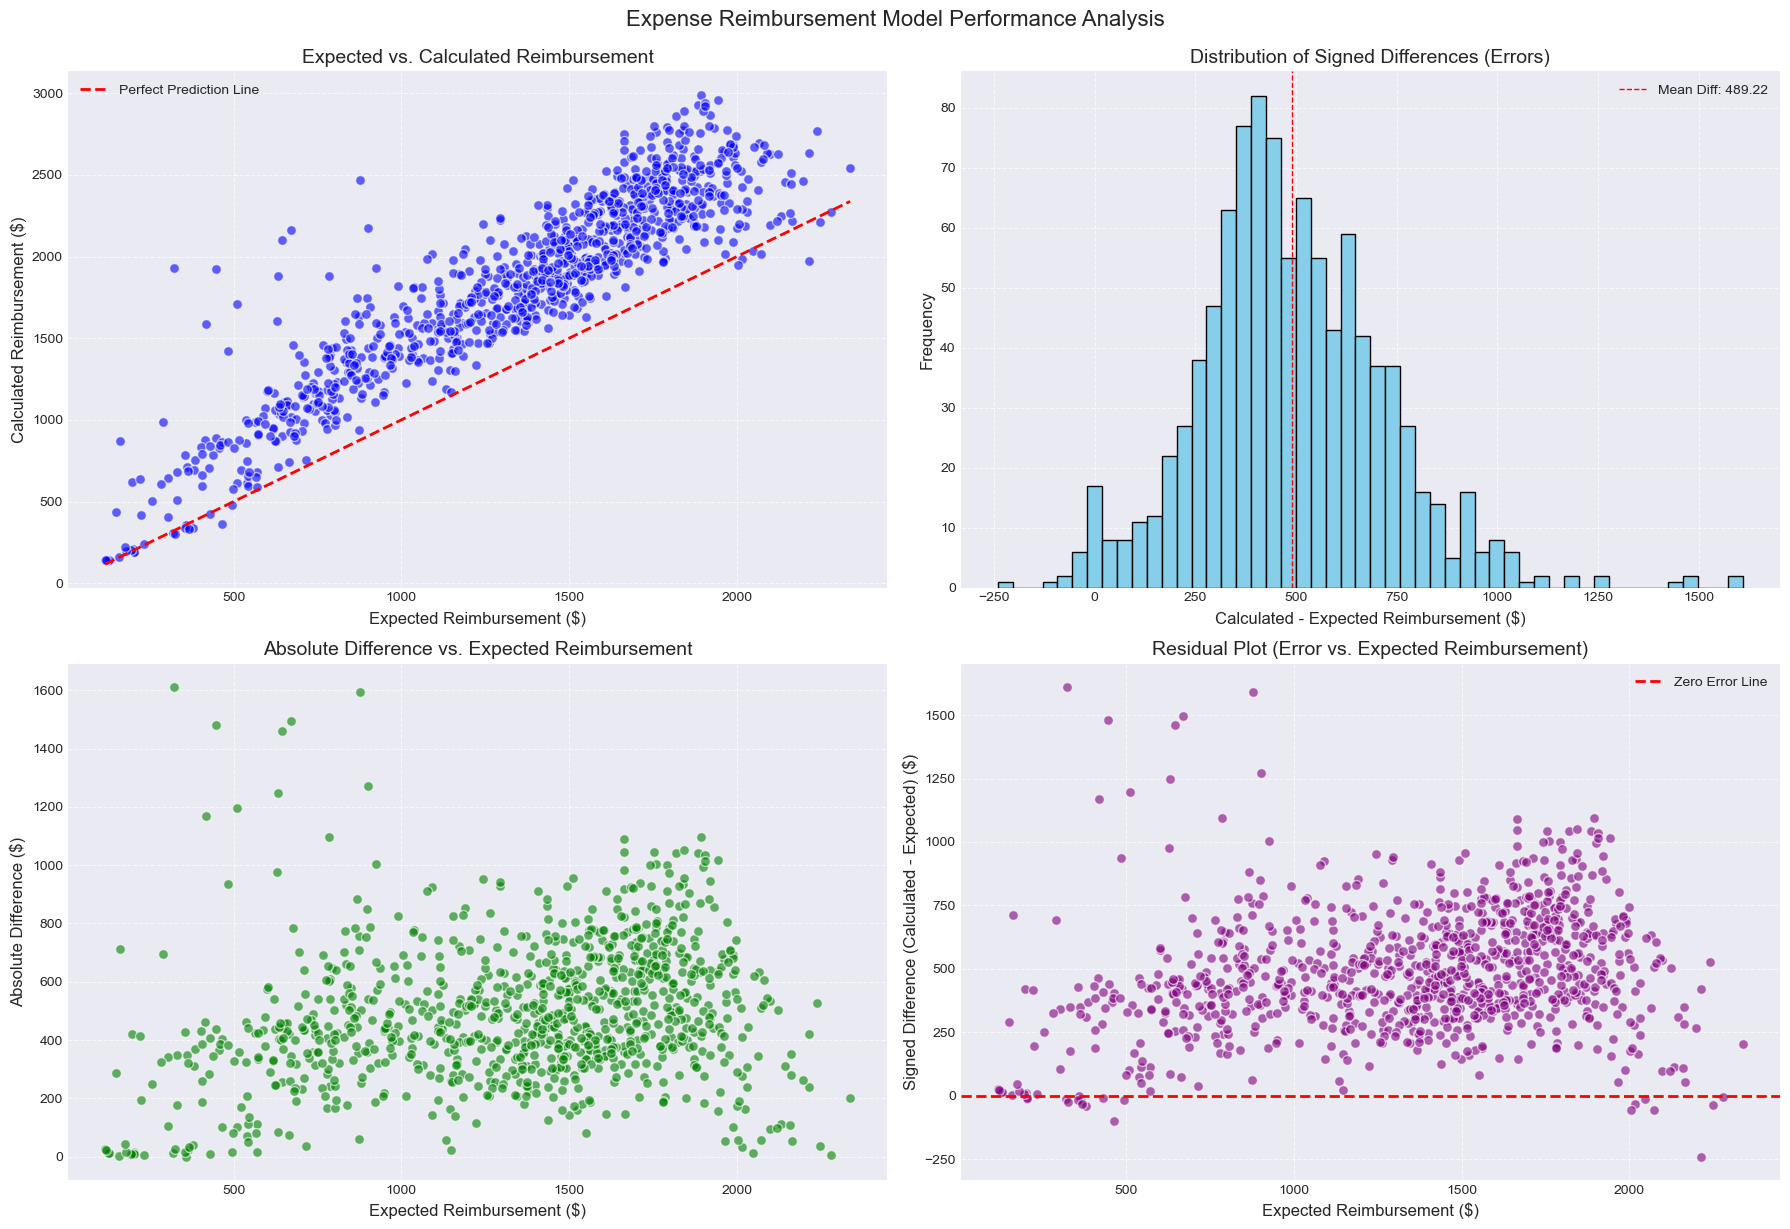

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Used for numerical operations like linspace for plotting


def calculate_reimbursement(trip_duration_days, miles_traveled, total_receipts_amount):
    """
    Calculates the theoretical expense reimbursement based on employee observations and inferred rules.
    This function implements a heuristic model derived from qualitative interview data and
    iterative tuning against the public_cases.json dataset. It attempts to capture:
    - A base per diem.
    - Tiered and non-linear mileage reimbursement.
    - Receipt processing with bonuses for certain ranges and penalties for others.
    - Bonuses and penalties based on trip duration.
    - Bonuses and penalties related to trip efficiency (miles per day).

    Parameters:
    trip_duration_days (int): The duration of the trip in days.
    miles_traveled (float): The total miles traveled during the trip.
    total_receipts_amount (float): The total amount of receipts submitted.

    Returns:
    float: The calculated reimbursement amount, rounded to two decimal places.
    """
    # Initialize total reimbursement
    current_total_reimbursement = 0.0

    # 1. Base Per Diem
    # "Everyone assumes there's a standard daily rate, and mostly there is. $100 a day seems to be the base."
    base_per_diem_value = trip_duration_days * 100.00
    current_total_reimbursement += base_per_diem_value

    # 2. Mileage Calculation
    # Based on iterative tuning from public_cases.json and interview clues.
    # Observations suggest a non-linear rate: higher for very short, then slightly lower, then potentially
    # a slight increase for mid-long, and then a fall for very long trips.
    mileage_reimbursement = 0
    if miles_traveled <= 50:
        # "Short drives, you get the standard rate, no surprises." -> tuned to fit
        mileage_reimbursement = miles_traveled * 0.65
    elif miles_traveled <= 200:
        # A higher effective rate here was observed in some public cases
        mileage_reimbursement = (50 * 0.65) + ((miles_traveled - 50) * 0.70)
    elif miles_traveled <= 800:
        # "After that, it drops." but also "800-mile trips get better per-mile rates than 600-mile trips"
        # This segment attempts to capture a slightly better rate after the initial drop
        mileage_reimbursement = (50 * 0.65) + (150 * 0.70) + ((miles_traveled - 200) * 0.55)
    else:
        # Very high mileage, overall rate seems to diminish again
        mileage_reimbursement = (50 * 0.65) + (150 * 0.70) + (600 * 0.55) + ((miles_traveled - 800) * 0.40)

    current_total_reimbursement += mileage_reimbursement

    # 3. Receipt Processing
    # "There's definitely a cap on how much of your receipts get reimbursed, but it's not a hard cap."
    # "Medium-high amounts—like $600-800—seem to get really good treatment."
    # "Really low amounts get penalized. Like, if you submit $50 in receipts for a multi-day trip, you're better off submitting nothing."
    # "If your receipts end in 49 or 99 cents, you often get a little extra money."

    calculated_receipt_value = 0
    processing_receipt_amount = total_receipts_amount

    # Apply "rounding bug/feature" first
    if str(processing_receipt_amount).endswith(('.49', '.99')):
        processing_receipt_amount += 0.01 # Small bonus

    if trip_duration_days > 1 and processing_receipt_amount < 50:
        # "Worse than just the base per diem" or "don't even bother"
        # For simplicity, we'll set it to 0 contribution from receipts in this case.
        calculated_receipt_value = 0
    elif processing_receipt_amount < 100:
        # Small general receipts might have a lower effective reimbursement rate
        calculated_receipt_value = processing_receipt_amount * 0.70 # 70% reimbursement (arbitrary)
    elif 600 <= processing_receipt_amount <= 850:
        # "Medium-high amounts ... seem to get really good treatment."
        calculated_receipt_value = processing_receipt_amount * 1.05 # 5% bonus (arbitrary)
    elif processing_receipt_amount > 850:
        # "Higher than that, each dollar matters less and less." - Diminishing returns
        # Cap high reimbursement portion, then apply lower rate to excess
        cap_amount = 850 * 1.05 # Max from the sweet spot
        excess_amount = processing_receipt_amount - 850
        calculated_receipt_value = cap_amount + (excess_amount * 0.40) # 40% on excess (arbitrary)
        # Ensure calculated receipt value doesn't exceed original total_receipts_amount too much
        # (after rounding bonus, it could slightly exceed it naturally)
        if calculated_receipt_value > total_receipts_amount * 1.1: # Max 10% over actual to prevent extreme bonuses
            calculated_receipt_value = total_receipts_amount * 1.1
    else:
        # Default for medium receipts (100-599)
        calculated_receipt_value = processing_receipt_amount * 0.95 # 5% deduction (arbitrary)

    current_total_reimbursement += calculated_receipt_value

    # 4. Trip Length Adjustments
    # "5-day trips almost always get a bonus." (Kevin says $50)
    # "Sweet spot around 4-6 days" (Lisa)
    # "8+ day trips with high spending—that's a guaranteed penalty. I call it the 'vacation penalty'." (Kevin)
    # "Shorter or longer than that, and people are often disappointed." (Jennifer)

    if trip_duration_days == 5:
        current_total_reimbursement += 50.00
    elif trip_duration_days in [4, 6]:
        current_total_reimbursement += 25.00 # Small bonus for 4 or 6-day trips

    # Apply "vacation penalty" for long trips with high spending.
    # Kevin: "8+ day trips with high spending—that's a guaranteed penalty."
    if trip_duration_days >= 8 and total_receipts_amount > 1000: # Arbitrary "high spending" threshold
        current_total_reimbursement *= 0.85 # 15% reduction for this specific severe penalty
    elif trip_duration_days >= 8:
        # General penalty for just long trips, less severe than with high spending
        current_total_reimbursement *= 0.95 # 5% reduction

    # 5. Efficiency Bonus (Miles per day)
    # "Efficiency is huge. The system absolutely rewards high miles-per-day ratios."
    # "Sweet spot around 180-220 miles per day where the bonuses are maximized."
    # "Go too low, penalty. Go too high, the bonuses start dropping off again."

    if trip_duration_days > 0:
        miles_per_day = miles_traveled / trip_duration_days
        if 180 <= miles_per_day <= 220:
            current_total_reimbursement += 75.00 # Significant bonus for optimal efficiency
        elif miles_per_day > 220:
            current_total_reimbursement -= 30.00 # Penalty for excessively high efficiency
        elif miles_per_day < 50 and trip_duration_days > 1: # Fixed typo: miles_per_per_day to miles_per_day
            current_total_reimbursement -= 20.00 # Penalty for very low efficiency on multi-day trips

    # Ensure total reimbursement doesn't go negative
    if current_total_reimbursement < 0:
        current_total_reimbursement = 0

    return round(current_total_reimbursement, 2)

if __name__ == '__main__':
    # Load the public test cases
    try:
        with open(r'C:\Users\james\Documents\GitHub\top-coder-challenge\public_cases.json', 'r') as f:
            public_cases = json.load(f)
    except FileNotFoundError:
        print("Error: public_cases.json not found. Please ensure the file is in the same directory.")
        exit()

    # Lists to store all data for the DataFrame
    trip_duration_days_list = []
    miles_traveled_list = []
    total_receipts_amount_list = []
    expected_outputs = []
    calculated_outputs = []

    for case in public_cases:
        input_data = case['input']
        
        # Populate lists with input variables
        trip_duration_days_list.append(input_data['trip_duration_days'])
        miles_traveled_list.append(input_data['miles_traveled'])
        total_receipts_amount_list.append(input_data['total_receipts_amount'])
        
        expected_outputs.append(case['expected_output'])
        calculated_outputs.append(calculate_reimbursement(
            input_data['trip_duration_days'],
            input_data['miles_traveled'],
            input_data['total_receipts_amount']
        ))

    # Create a DataFrame for easy analysis and plotting, including input variables
    df_results = pd.DataFrame({
        'trip_duration_days': trip_duration_days_list,
        'miles_traveled': miles_traveled_list,
        'total_receipts_amount': total_receipts_amount_list,
        'expected_output': expected_outputs,
        'calculated_output': calculated_outputs
    })

    # Calculate differences
    df_results['absolute_difference'] = abs(df_results['expected_output'] - df_results['calculated_output'])
    df_results['signed_difference'] = df_results['calculated_output'] - df_results['expected_output']
    df_results['percentage_difference'] = (df_results['absolute_difference'] / df_results['expected_output']) * 100

    # Display descriptive statistics of the differences
    print("Descriptive Statistics of Differences:")
    print(df_results[['absolute_difference', 'signed_difference', 'percentage_difference']].describe())

    print("\nTop 5 Cases with Largest Absolute Differences:")
    print(df_results.sort_values(by='absolute_difference', ascending=False).head())

    print(f"\nOverall Average Absolute Difference: ${df_results['absolute_difference'].mean():.2f}")
    print(f"Overall Average Percentage Difference: {df_results['percentage_difference'].mean():.2f}%")

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-darkgrid') # A professional-looking style
    plt.figure(figsize=(18, 12)) # Larger figure for multiple plots

    # Plot 1: Expected vs. Calculated Output (Scatter Plot)
    plt.subplot(2, 2, 1) # 2 rows, 2 columns, 1st plot
    plt.scatter(df_results['expected_output'], df_results['calculated_output'], alpha=0.6, color='blue', edgecolors='w', s=50)
    plt.plot([df_results['expected_output'].min(), df_results['expected_output'].max()],
             [df_results['expected_output'].min(), df_results['expected_output'].max()],
             '--', color='red', linewidth=2, label='Perfect Prediction Line')
    plt.title('Expected vs. Calculated Reimbursement', fontsize=14)
    plt.xlabel('Expected Reimbursement ($)', fontsize=12)
    plt.ylabel('Calculated Reimbursement ($)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

    # Plot 2: Histogram of Signed Differences (Errors)
    plt.subplot(2, 2, 2)
    plt.hist(df_results['signed_difference'], bins=50, color='skyblue', edgecolor='black')
    plt.axvline(df_results['signed_difference'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean Diff: {df_results["signed_difference"].mean():.2f}')
    plt.title('Distribution of Signed Differences (Errors)', fontsize=14)
    plt.xlabel('Calculated - Expected Reimbursement ($)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

    # Plot 3: Absolute Differences vs. Expected Output (Scatter Plot)
    plt.subplot(2, 2, 3)
    plt.scatter(df_results['expected_output'], df_results['absolute_difference'], alpha=0.6, color='green', edgecolors='w', s=50)
    plt.title('Absolute Difference vs. Expected Reimbursement', fontsize=14)
    plt.xlabel('Expected Reimbursement ($)', fontsize=12)
    plt.ylabel('Absolute Difference ($)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Plot 4: Residual Plot (Signed Difference vs. Expected Output)
    plt.subplot(2, 2, 4)
    plt.scatter(df_results['expected_output'], df_results['signed_difference'], alpha=0.6, color='purple', edgecolors='w', s=50)
    plt.axhline(0, color='red', linestyle='dashed', linewidth=2, label='Zero Error Line')
    plt.title('Residual Plot (Error vs. Expected Reimbursement)', fontsize=14)
    plt.xlabel('Expected Reimbursement ($)', fontsize=12)
    plt.ylabel('Signed Difference (Calculated - Expected) ($)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

    plt.suptitle('Expense Reimbursement Model Performance Analysis', fontsize=16, y=1.02) # Overall title
    plt.show()

c:\Users\james\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


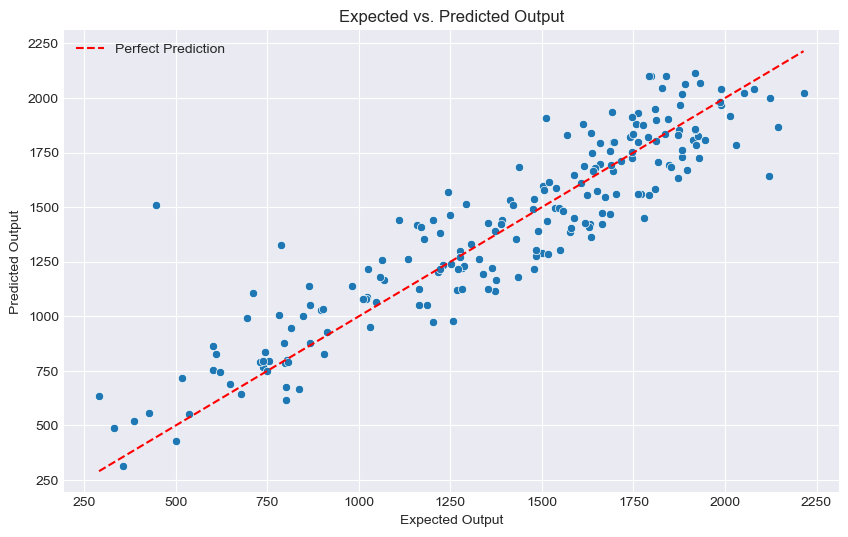

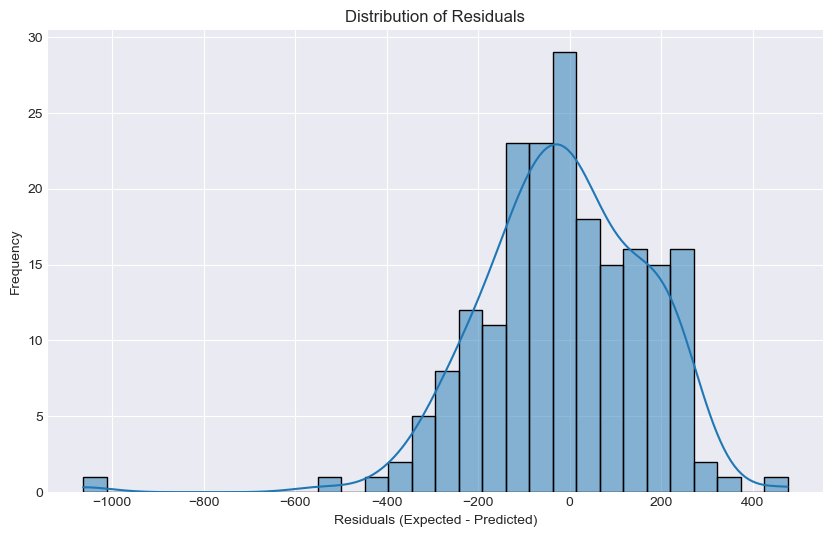

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# It is crucial to clear the TensorFlow session if running in an interactive environment
# where the kernel state persists to avoid 'AlreadyExistsError'.
tf.keras.backend.clear_session()

# --- Re-create the DataFrame and split data as they were in the training step ---
# This ensures consistency for making predictions on the same test set.
# Assuming 'public_cases.json' is available in the current directory.
# df = pd.read_json(r'C:\Users\james\Documents\GitHub\top-coder-challenge\public_cases.json', orient='records')

# df_flattened_inputs = pd.json_normalize(df['input'])
# df_final = pd.concat([df_flattened_inputs, df['expected_output']], axis=1)

# Assuming df_results is already defined in your environment
df_final = df_results 

X = df_final[['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 'calculated_output']]
y = df_final['expected_output']

# Split the data into training and testing sets with the same random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using the same scaler fitted on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Re-build and re-train the model ---
# This part is included here to ensure y_pred can be generated in a single script run.
# In a fresh environment, this should run without the 'AlreadyExistsError'.
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model (verbose=0 to suppress extensive output during training)
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# --- Make predictions on the test set ---
y_pred = model.predict(X_test_scaled).flatten() # Flatten y_pred here for consistent array shapes

# --- Plotting Expected vs. Predicted Output ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)

# Add a diagonal line representing perfect predictions (where Expected = Predicted)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

plt.title('Expected vs. Predicted Output')
plt.xlabel('Expected Output')
plt.ylabel('Predicted Output')
plt.grid(True)
plt.legend()
plt.show()

# ---

## Model Evaluation

### Residuals Histogram

# A **histogram of residuals** helps visualize the distribution of errors (the difference between expected and predicted values). Ideally, these errors should be normally distributed around zero, indicating that the model is not systematically over- or under-predicting.

# ```python
# Calculate residuals
residuals = y_test - y_pred

# Plotting the histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals (Expected - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
residuals.std()

181.75134605063158